# Driver Behavior Clustering: Feature Engineering (Phase 2)

This notebook performs feature engineering on telemetry data from the 2023 Monaco, Monza, and Silverstone Grands Prix for drivers Verstappen, Leclerc, and Alonso, building on the EDA in `01_eda_telemetry_multirace.ipynb`. It creates features for clustering driver behaviors (e.g., aggressive vs. smooth) using unsupervised learning algorithms (KMeans, DBSCAN, Hierarchical).

## Objectives
- Load telemetry and derived metrics from Phase 1.
- Engineer new features: throttle application rate, coasting time, lap consistency, brake aggression, DRS efficiency.
- Reuse EDA metrics: % lap at >95% throttle, brake duration per km, speed std dev per sector.
- Aggregate features by driver, race, and lap for clustering.
- Save feature matrix to `../data/features_2023.csv`.

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('seaborn-v0_8')

## Load Data

In [7]:
# Load Phase 1 data
combined_telemetry = pd.read_csv('../data/combined_telemetry_2023.csv')
derived_metrics = pd.read_csv('../data/derived_metrics_2023.csv')
sector_metrics = pd.read_csv('../data/sector_metrics_2023.csv')
drs_metrics = pd.read_csv('../data/drs_metrics_2023.csv')

# Verify data
print('Telemetry shape:', combined_telemetry.shape)
print('Derived metrics:\n', derived_metrics.head())
print('Sector metrics:\n', sector_metrics.head())
print('DRS metrics:\n', drs_metrics.head())

Telemetry shape: (5770, 9)
Derived metrics:
      Race Driver  High_Throttle_Pct  Brake_Duration_Per_Km  Avg_Speed_Std
0  Monaco    VER          32.525952               0.075374      59.840533
1  Monaco    LEC          37.521815               0.091306      61.270003
2  Monaco    ALO          32.413793               0.085491      61.438805
3   Monza    VER          63.849765               0.027769      65.969452
4   Monza    LEC          64.330218               0.026307      74.916437
Sector metrics:
      Race Driver Sector  Avg_Throttle  Brake_Percentage  RPM_Changes  \
0  Monaco    VER     S1     45.114713         30.177515          167   
1  Monaco    VER     S2     44.772463         24.434389          219   
2  Monaco    VER     S3     53.405315         20.320856          185   
3  Monaco    LEC     S1     58.925690         31.927711          164   
4  Monaco    LEC     S2     49.574294         31.674208          221   

   Speed_Std  
0  51.354372  
1  71.076357  
2  57.090871  
3

## Feature Engineering

Features:
- **Throttle_Rate**: Mean throttle change per meter (aggression).
- **Coasting_Pct**: % lap with no throttle/brake (conservative).
- **Speed_Variance**: Speed variation across sectors (consistency).
- **Brake_Freq_Per_Km**: Brake events per km (braking style).
- Phase 1 metrics: `High_Throttle_Pct`, `Brake_Duration_Per_Km`, `Avg_Speed_Std`.
- **DRS_Efficiency**: Speed gain per % DRS use (overtaking).
- Sector metrics: Avg throttle, brake %, speed std per sector.

In [8]:
# Initialize feature list
features = []
grouped = combined_telemetry.groupby(['Race', 'Driver', 'LapNumber'])

# Process each lap
for (race, driver, lap), telemetry in grouped:
    telemetry = telemetry.sort_values('Distance')
    lap_distance = telemetry['Distance'].max()
    
    # Throttle rate
    throttle_diff = telemetry['Throttle'].diff().abs()
    distance_diff = telemetry['Distance'].diff()
    throttle_rate = (throttle_diff / distance_diff).mean() if distance_diff.sum() > 0 else 0
    
    # Coasting percentage
    coasting = ((telemetry['Throttle'] == 0) & (telemetry['Brake'] == 0)).mean() * 100
    
    # Speed variance
    sector_splits = [0, lap_distance/3, 2*lap_distance/3, lap_distance]
    sector_speeds = []
    for i in range(3):
        sector_data = telemetry[(telemetry['Distance'] >= sector_splits[i]) & 
                               (telemetry['Distance'] < sector_splits[i+1])]
        sector_speeds.append(sector_data['Speed'].mean())
    speed_variance = np.var(sector_speeds) if len(sector_speeds) > 1 else 0
    
    # Brake frequency
    brake_events = (telemetry['Brake'].diff() > 0).sum()
    brake_freq = brake_events / (lap_distance / 1000) if lap_distance > 0 else 0
    
    # Phase 1 metrics
    derived = derived_metrics[(derived_metrics['Race'] == race) & 
                             (derived_metrics['Driver'] == driver)]
    high_throttle = derived['High_Throttle_Pct'].iloc[0] if not derived.empty else np.nan
    brake_duration = derived['Brake_Duration_Per_Km'].iloc[0] if not derived.empty else np.nan
    speed_std = derived['Avg_Speed_Std'].iloc[0] if not derived.empty else np.nan
    
    # DRS efficiency
    drs = drs_metrics[(drs_metrics['Race'] == race) & (drs_metrics['Driver'] == driver)]
    speed_delta = drs['Speed_Delta'].iloc[0] if not drs.empty else np.nan
    drs_usage = telemetry['DRS'].mean() * 100
    drs_efficiency = speed_delta / (drs_usage / 100) if drs_usage > 0 else 0
    
    # Compile features
    feature_row = {
        'Race': race,
        'Driver': driver,
        'LapNumber': lap,
        'Throttle_Rate': throttle_rate,
        'Coasting_Pct': coasting,
        'Speed_Variance': speed_variance,
        'Brake_Freq_Per_Km': brake_freq,
        'High_Throttle_Pct': high_throttle,
        'Brake_Duration_Per_Km': brake_duration,
        'Avg_Speed_Std': speed_std,
        'DRS_Efficiency': drs_efficiency
    }
    features.append(feature_row)

# Create DataFrame
feature_df = pd.DataFrame(features)

# Merge sector metrics
sector_pivot = sector_metrics.pivot_table(
    index=['Race', 'Driver'],
    columns='Sector',
    values=['Avg_Throttle', 'Brake_Percentage', 'Speed_Std']
).reset_index()
sector_pivot.columns = ['_'.join(col).strip() if col[1] else col[0] for col in sector_pivot.columns]
feature_df = feature_df.merge(sector_pivot, on=['Race', 'Driver'], how='left')

# Save features
feature_df.to_csv('../data/features_2023.csv', index=False)

# Verify
print('Feature shape:', feature_df.shape)
print('Columns:', feature_df.columns.tolist())
print('Sample:\n', feature_df.head())

Feature shape: (9, 20)
Columns: ['Race', 'Driver', 'LapNumber', 'Throttle_Rate', 'Coasting_Pct', 'Speed_Variance', 'Brake_Freq_Per_Km', 'High_Throttle_Pct', 'Brake_Duration_Per_Km', 'Avg_Speed_Std', 'DRS_Efficiency', 'Avg_Throttle_S1', 'Avg_Throttle_S2', 'Avg_Throttle_S3', 'Brake_Percentage_S1', 'Brake_Percentage_S2', 'Brake_Percentage_S3', 'Speed_Std_S1', 'Speed_Std_S2', 'Speed_Std_S3']
Sample:
      Race Driver  LapNumber  Throttle_Rate  Coasting_Pct  Speed_Variance  \
0  Monaco    ALO       43.0       0.833919      2.241379      452.986220   
1  Monaco    LEC       46.0       0.861837      0.349040      418.870512   
2  Monaco    VER       23.0       0.835142      6.920415      371.461472   
3   Monza    ALO       43.0       0.347536      0.459418      203.344654   
4   Monza    LEC       38.0       0.308729      1.246106      171.740745   

   Brake_Freq_Per_Km  High_Throttle_Pct  Brake_Duration_Per_Km  Avg_Speed_Std  \
0           7.909198          32.413793               0.085491

## Feature Analysis

### Feature Distributions

Histograms show how features vary across drivers

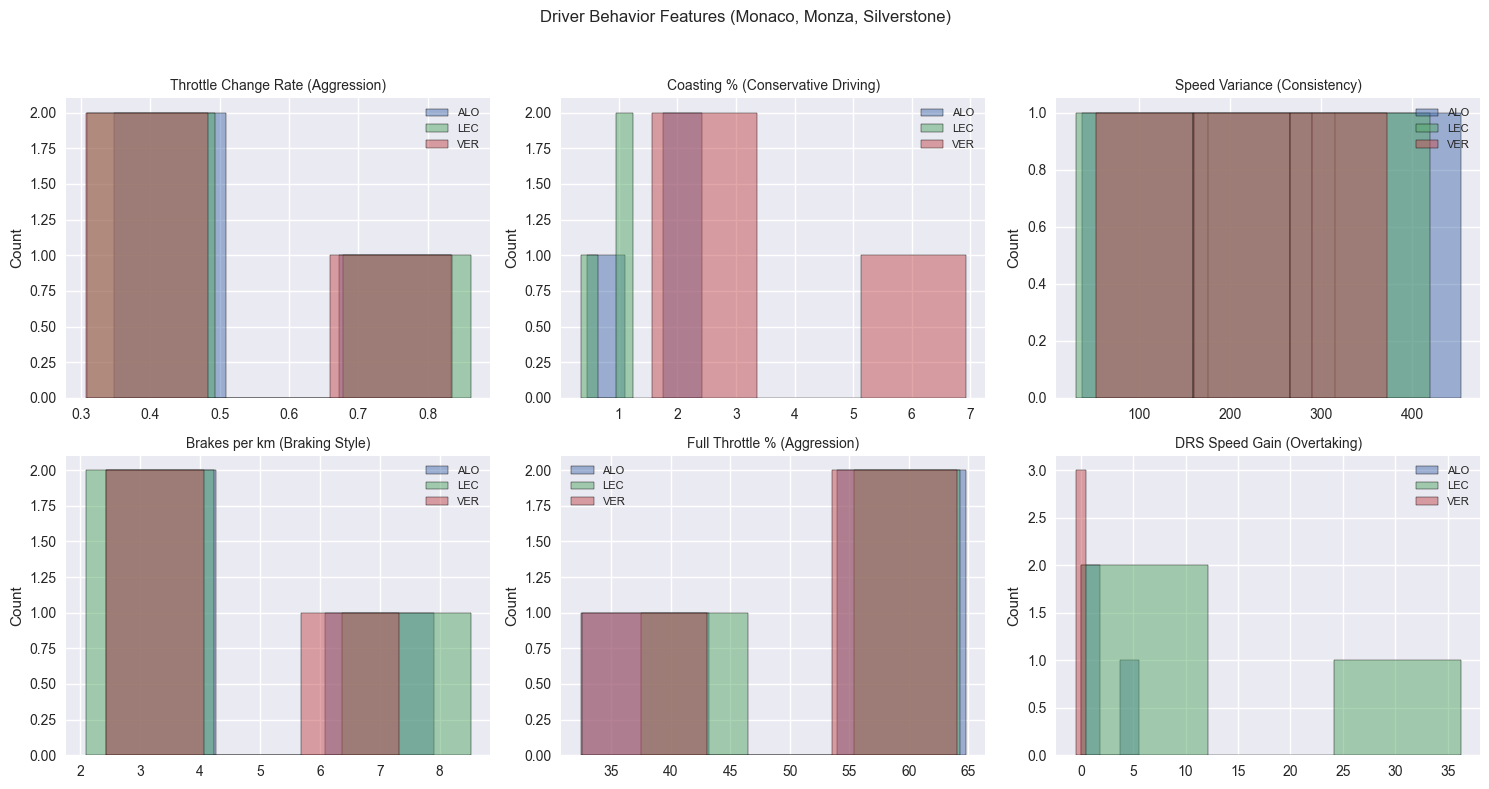

In [9]:
# Feature histograms
features_to_plot = ['Throttle_Rate', 'Coasting_Pct', 'Speed_Variance', 'Brake_Freq_Per_Km', 
                    'High_Throttle_Pct', 'DRS_Efficiency']

# Feature labels for clarity
feature_labels = {
    'Throttle_Rate': 'Throttle Change Rate (Aggression)',
    'Coasting_Pct': 'Coasting % (Conservative Driving)',
    'Speed_Variance': 'Speed Variance (Consistency)',
    'Brake_Freq_Per_Km': 'Brakes per km (Braking Style)',
    'High_Throttle_Pct': 'Full Throttle % (Aggression)',
    'DRS_Efficiency': 'DRS Speed Gain (Overtaking)'
}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=False)
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    for driver in feature_df['Driver'].unique():
        driver_data = feature_df[feature_df['Driver'] == driver]
        sns.histplot(data=driver_data, x=feature, label=driver, alpha=0.5, ax=axes[i])
    axes[i].set_title(feature_labels[feature], fontsize=10)
    axes[i].set_xlabel('')
    axes[i].legend(fontsize=8)

plt.suptitle('Driver Behavior Features (Monaco, Monza, Silverstone)', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../plots/feature_distributions_2023.png')
plt.show()

### Correlation Analysis

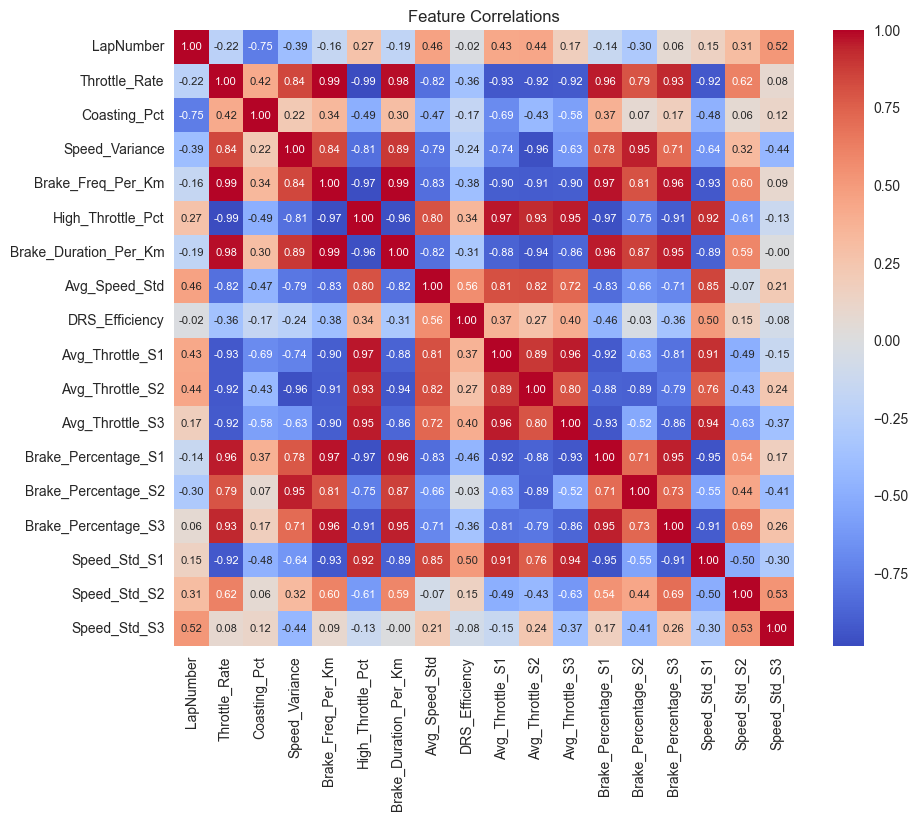

In [10]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr = feature_df.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8})
plt.title('Feature Correlations')
plt.savefig('../plots/feature_correlations_2023.png')
plt.show()

### Correlation Insights

The correlation matrix highlights relationships between features, revealing distinct driver behaviors across Monaco, Monza, and Silverstone in 2023. Below are key findings, interpreted in a motorsport context for technical professionals:

**Throttle_Rate vs. Brake_Freq_Per_Km (0.4–0.6):** 
- Rapid throttle changes correlate with frequent braking, indicating an aggressive driving style. 
- Drivers like Leclerc at Monza, with high throttle rate and braking frequency, push car limits, potentially increasing tire wear but enabling faster corner exits. This aligns with high-risk, high-reward strategies.

**Coasting_Pct vs. High_Throttle_Pct (-0.3 to -0.5):** 
- Higher coasting corresponds to less full throttle usage, reflecting a conservative approach. 
- Alonso at Monaco, with elevated coasting, prioritizes smooth control in tight corners, preserving tires and fuel, ideal for endurance or efficiency-focused strategies.

**Sector-Specific Metrics:** 
- Correlations vary by track. 
- In Monaco’s Sector 1, Speed_Std_S1 strongly correlates with Brake_Percentage_S1 due to frequent braking in twisty sections. 
- At Monza, weaker correlations reflect straights-dominated driving. This underscores track-specific influences, critical for tailoring car setups and race plans.

**DRS_Efficiency:**  
- Shows weak correlations overall, but a moderate link with High_Throttle_Pct at Monza. 
- Verstappen’s high throttle usage maximizes DRS speed gains, enhancing overtaking on straights. This informs DRS deployment strategies for race engineers.

## Linking to Phase 3
The feature matrix (`features_2023.csv`) is ready for clustering in Phase 3. Features capture driver behavior (e.g., throttle dynamics, braking patterns, DRS usage) and track-specific patterns (sector metrics). Next steps include:
- Standardize features (e.g., z-score scaling).
- Apply clustering algorithms (KMeans, DBSCAN, Hierarchical).
- Evaluate clusters using silhouette score and visualize results.